# Problème de coloration de cartes (version CSP)

In [1]:
import fiona
import geopandas as gpd
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import rc
rc('text', usetex=True)

## Import

In [2]:
fp = f'../export/india.shp'
map_df = gpd.read_file(fp)
map_df = map_df.sort_values('var_name')
map_df.head()

var_name var_name_t  \
0     Andhra Pradesh   $x_{ap}$   
1  Arunachal Pradesh   $x_{ar}$   
2              Assam   $x_{as}$   
3              Bihar   $x_{br}$   
4         Chandigarh   $x_{ch}$   

                                           neighbors  \
0  ['Karnataka', 'Odisha', 'Puducherry', 'Tamil N...   
1                              ['Assam', 'Nagaland']   
2  ['Arunachal Pradesh', 'Manipur', 'Meghalaya', ...   
3      ['Jharkhand', 'Uttar Pradesh', 'West Bengal']   
4                              ['Haryana', 'Punjab']   

                                            geometry  
0  MULTIPOLYGON (((80.19264 13.52070, 80.19264 13...  
1  POLYGON ((96.15778 29.38310, 96.16380 29.37668...  
2  MULTIPOLYGON (((89.87145 25.53730, 89.87118 25...  
3  MULTIPOLYGON (((88.10548 26.53904, 88.10505 26...  
4  POLYGON ((76.80293 30.67548, 76.79437 30.66932...

## Formulation des données

In [3]:
# Données comprenant le nombre de variables et l'ensemble des paires de voisins
data = {
    'n_var': len(map_df),
    'neighbors': []
}

var_number = 0
variables = dict()

for _, region in map_df.iterrows():
    variables[region.var_name] = var_number
    var_number += 1

for _, region in map_df.iterrows():
    r = region.var_name
    n_list = eval(region.neighbors)
    
    for n in n_list:
        if r < n:
            data['neighbors'].append((variables[r],  variables[n]))

# Export dans data.json pour PyCSP3
with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

## Exécution de PyCSP3 pour modéliser et résoudre le CSP

Il suffit pour cela d'exécuter la commande

```bash
python3 graph-coloring.py -data=india-data.json -solve
```

puis de renommer l'output en `solver.log` pour être interpréter dans le reste de ce notebook.

## Récupération de la solution interprétée comme couleurs

In [4]:
import re

with open('solver.log', 'r') as solver_log:
    for line in solver_log:
        #print(line)
        if m := re.match('.*?regions: \[(.*)\]', line):
            sol = m.group(1)
            
color = [int(c) for c in sol.split(',')]

map_df['color'] = color
print(color)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 3, 0, 0, 2, 0, 2, 3, 1, 2, 0, 0, 2, 2, 0, 3, 1, 2]


## Génération de la carte avec les solutions du solveur

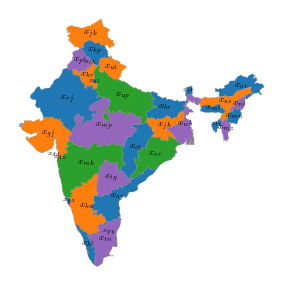

In [5]:
map_df1 = map_df.copy()
map_df1['geometry'] = map_df1.apply(lambda x: x['geometry'].simplify(tolerance=.01, preserve_topology=True), axis=1)

colormap = ListedColormap(['#1f77b4', '#ff7f0e', 'white', '#9467bd', '#2ca02c'])
ax = map_df1.plot(figsize=(5,5), edgecolor='gray', linewidth=.2, column='color', cmap=colormap)
ax.axis('off')
map_df1.apply(lambda x: ax.annotate(text=x.var_name_t, xy=x.geometry.centroid.coords[0], ha='center', size=9 if x['geometry'].area > 1 else 6), axis=1)

plt.savefig('output/colored_india.pdf', transparent=True, bbox_inches='tight', dpi=600, pad_inches=-.15)

## Génération de la carte avec insertion d'une incohérence dans la solution du solveur

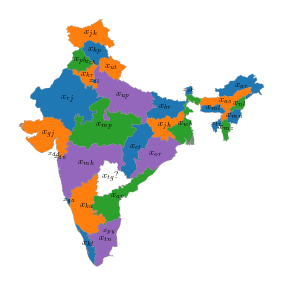

In [6]:
map_df2 = map_df.copy()
map_df2['geometry'] = map_df2.apply(lambda x: x['geometry'].simplify(tolerance=.01, preserve_topology=True), axis=1)

map_df2.loc[29, 'color'] = 4
map_df2.loc[29, 'var_name_t'] = '$x_{tg} ?$'
map_df2.loc[0, 'color'] = 2
map_df2.loc[28, 'color'] = 3


colormap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', 'white'])
ax = map_df2.plot(figsize=(5,5), edgecolor='gray', linewidth=.2, column='color', cmap=colormap)
ax.axis('off')
map_df2.apply(lambda x: ax.annotate(text=x.var_name_t, xy=x.geometry.centroid.coords[0], ha='center', size=9 if x['geometry'].area > 1 else 6), axis=1)

plt.savefig('output/almost_colored_india.pdf', transparent=True, bbox_inches='tight', dpi=600, pad_inches=-.15)